<a href="https://colab.research.google.com/github/rekuliev/clfs_analysis/blob/main/testwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from itertools import combinations
from scipy.stats import zscore, t

from sklearn.datasets import make_moons

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, auc

import sklearn.svm as svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Introduction

Here we should get input data, we can also see at data distribution in plot, and standardize values

As a standardize method will be used z-score as aa rather comfortable and suitable for input data

In [ ]:
# Input data
X, y = make_moons(n_samples=1000, noise=0.5, random_state=0)
# Standardize X values with z-score method
X_st = zscore(X, ddof=0)

In [ ]:
# Present the data as a dataframe for convenience
input_data = pd.DataFrame(dict(x1=X_st[:, 0], x2=X_st[:, 1], y=y))
input_data.head()

,x1,x2,y
0,1.703339,0.700255,1
1,1.544985,0.254726,1
2,-0.620411,-0.336854,0
3,-1.211937,-0.046722,1
4,-0.237586,-0.990476,1


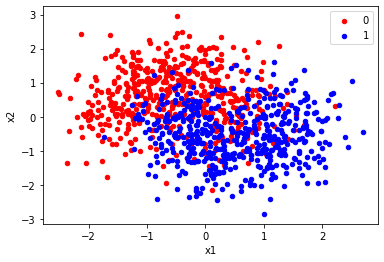

In [ ]:
# Consider input data with a scatter plot
colors = {0: 'red', 1: 'blue'}
groups = input_data.groupby('y')
fig, ax = plt.subplots()
for key, group in groups:
    group.plot(ax=ax, x='x1', y='x2', label=key, color=colors[key], kind='scatter')
plt.show()

# Part one

## Classification training

At that part there is following challenges:
1. Split input data to test and train samples
2. Define classificators, that will be compared during the work
3. Tune parameters for classification

Grid search method is choisen for the tuning as a standart way, but in perspective it could be Bayesian optimization

In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(input_data.iloc[:, :2], y, test_size=0.33, random_state=42)

In [ ]:
# Define classificators

# As a boost algorithm the gradient boost method was choisen

# For linear svm classificator parameter dual was defined as False, 
# because number of samples is bigger than number of features

lin_svm_clf = svm.LinearSVC(dual=False, penalty='l2')
rbf_svm_clf = svm.SVC(kernel='rbf')
tree_clf = DecisionTreeClassifier()
forest_clf = RandomForestClassifier()
grad_boost_clf = GradientBoostingClassifier(learning_rate=0.2)
knn_clf = KNeighborsClassifier()

In [ ]:
# Choice of parameters for tuning

# Step 1: Estimation of parameters

param_lsvm = {
    'C': [1, 10, 100, 1000],
    'max_iter': list(range(10, 110, 10))
}
param_rbfsvm = {
    'C': [1, 10, 100, 1000],
    'gamma': ['scale', 'auto']   
}
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 11)),
    'min_samples_split': list(range(2, 51, 5)),
    'min_samples_leaf': list(range(1, 51, 5))
}
param_forest= {
    'n_estimators': list(range(20, 120, 20)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 11)),
    #'min_samples_split': list(range(2, 51, 5)),
    #'min_samples_leaf': list(range(1, 51, 5))
}
param_boost = {
    'loss': ['deviance', 'exponential'],
    'criterion': ['friedman_mse', 'mse', 'mae'],
    'max_depth': list(range(1, 11)),
    #'min_samples_split': list(range(2, 51, 5)),
    #'min_samples_leaf': list(range(1, 51, 5)),
}
param_knn = {
    'n_neighbors': list(range(2, 50)),
    'weights': ['uniform', 'distance'],
    'leaf_size': list(range(2, 100, 5)),
    'p': [1, 2]
}

In [ ]:
# Tuning parameters

grid_search_cv_lsvm = GridSearchCV(lin_svm_clf, param_lsvm, cv=5)
grid_search_cv_lsvm.fit(X_train, y_train)
print('lsvm done')
grid_search_cv_rbfsvm = GridSearchCV(rbf_svm_clf, param_rbfsvm, cv=5)
grid_search_cv_rbfsvm.fit(X_train, y_train)
print('rbfsvm done')
grid_search_cv_dt = GridSearchCV(tree_clf, param_dt, cv=5)
grid_search_cv_dt.fit(X_train, y_train)
print('dt done')
grid_search_cv_forest = GridSearchCV(forest_clf, param_forest, cv=5)
grid_search_cv_forest.fit(X_train, y_train)
print('forest done')
grid_search_cv_boost = GridSearchCV(grad_boost_clf, param_boost, cv=5)
grid_search_cv_boost.fit(X_train, y_train)
print('boost done')
grid_search_cv_knn = GridSearchCV(knn_clf, param_knn, cv=5)
grid_search_cv_knn.fit(X_train, y_train)
print('knn done')

lsvm done
rbfsvm done
dt done
forest done
boost done
knn done


In [ ]:
lin_svm_clf = grid_search_cv_lsvm.best_estimator_
rbf_svm_clf = grid_search_cv_rbfsvm.best_estimator_
tree_clf = grid_search_cv_dt.best_estimator_
forest_clf = grid_search_cv_forest.best_estimator_
grad_boost_clf = grid_search_cv_boost.best_estimator_
knn_clf = grid_search_cv_knn.best_estimator_
clfs = [lin_svm_clf, rbf_svm_clf, tree_clf, forest_clf, grad_boost_clf, knn_clf]
for clf in clfs:
    print(clf)

LinearSVC(C=1, dual=False, max_iter=10)
SVC(C=10, gamma='auto')
DecisionTreeClassifier(max_depth=10, min_samples_split=42)
RandomForestClassifier(max_depth=3, n_estimators=80)
GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=1)
KNeighborsClassifier(leaf_size=2, n_neighbors=27)


In [ ]:
clfs = [lin_svm_clf, rbf_svm_clf, tree_clf, forest_clf, grad_boost_clf, knn_clf]
for clf in clfs:
    print(clf)

LinearSVC(C=1, dual=False, max_iter=10)
SVC(C=10, gamma='auto')
DecisionTreeClassifier(max_depth=10, min_samples_split=42)
RandomForestClassifier(max_depth=3, n_estimators=80)
GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=1)
KNeighborsClassifier(leaf_size=2, n_neighbors=27)


In [ ]:
# Step 2: Clarification of parameters

param_lsvm = {
    'C': list(range(1, 11)),
    'max_iter': list(range(5, 11))
}
param_rbfsvm = {
    'C': list(np.arange(1, 20)),   
}
param_dt = {
    'max_depth': list(range(9, 16)),
    'min_samples_split': list(range(37, 48)),
    'min_samples_leaf': list(range(1, 6))
}
param_forest= {
    'min_samples_split': list(range(2, 51, 5)),
    'min_samples_leaf': list(range(1, 51, 5)),
}
param_boost = {
    'learning_rate': [0.1],
    'max_depth': list(range(1, 4)),
    'min_samples_split': list(range(2, 51, 5)),
    'min_samples_leaf': list(range(1, 51, 5)),
}
param_knn = {
    'leaf_size': list(range(2, 7)),
}

In [ ]:
# Retuning parameters

grid_search_cv_lsvm = GridSearchCV(lin_svm_clf, param_lsvm, cv=5)
grid_search_cv_lsvm.fit(X_train, y_train)
print('lsvm done')
grid_search_cv_rbfsvm = GridSearchCV(rbf_svm_clf, param_rbfsvm, cv=5)
grid_search_cv_rbfsvm.fit(X_train, y_train)
print('rbfsvm done')
grid_search_cv_dt = GridSearchCV(tree_clf, param_dt, cv=5)
grid_search_cv_dt.fit(X_train, y_train)
print('dt done')
grid_search_cv_forest = GridSearchCV(forest_clf, param_forest, cv=5)
grid_search_cv_forest.fit(X_train, y_train)
print('forest done')
grid_search_cv_boost = GridSearchCV(grad_boost_clf, param_boost, cv=5)
grid_search_cv_boost.fit(X_train, y_train)
print('boost done')
grid_search_cv_knn = GridSearchCV(knn_clf, param_knn, cv=5)
grid_search_cv_knn.fit(X_train, y_train)
print('knn done')

lsvm done
rbfsvm done
dt done
forest done
boost done
knn done


In [ ]:
lin_svm_clf = grid_search_cv_lsvm.best_estimator_
rbf_svm_clf = grid_search_cv_rbfsvm.best_estimator_
tree_clf = grid_search_cv_dt.best_estimator_
forest_clf = grid_search_cv_forest.best_estimator_
grad_boost_clf = grid_search_cv_boost.best_estimator_
knn_clf = grid_search_cv_knn.best_estimator_
clfs = [lin_svm_clf, rbf_svm_clf, tree_clf, forest_clf, grad_boost_clf, knn_clf]
for clf in clfs:
    print(clf)

LinearSVC(C=1, dual=False, max_iter=5)
SVC(C=10, gamma='auto')
DecisionTreeClassifier(max_depth=10, min_samples_split=41)
RandomForestClassifier(max_depth=3, min_samples_leaf=11, min_samples_split=27,
                       n_estimators=80)
GradientBoostingClassifier(loss='exponential', max_depth=1, min_samples_leaf=31)
KNeighborsClassifier(leaf_size=2, n_neighbors=27)


In [ ]:
# Still clarification of parameters

param_lsvm = {
    'C': list(np.arange(0.05, 1.05, 0.05)),
}
param_rbfsvm = {
    'C': list(np.arange(9.0, 11.0, 0.1)),   
}
param_forest= {
    'min_samples_split': list(range(17, 27)),
    'min_samples_leaf': list(range(7, 17)),
}

In [ ]:
# Retuning parameters

grid_search_cv_lsvm = GridSearchCV(lin_svm_clf, param_lsvm, cv=5)
grid_search_cv_lsvm.fit(X_train, y_train)
print('lsvm done')
grid_search_cv_rbfsvm = GridSearchCV(rbf_svm_clf, param_rbfsvm, cv=5)
grid_search_cv_rbfsvm.fit(X_train, y_train)
print('rbfsvm done')
grid_search_cv_forest = GridSearchCV(forest_clf, param_forest, cv=5)
grid_search_cv_forest.fit(X_train, y_train)
print('forest done')

lsvm done
rbfsvm done
forest done


In [ ]:
lin_svm_clf = grid_search_cv_lsvm.best_estimator_
rbf_svm_clf = grid_search_cv_rbfsvm.best_estimator_
tree_clf = grid_search_cv_dt.best_estimator_
forest_clf = grid_search_cv_forest.best_estimator_
grad_boost_clf = grid_search_cv_boost.best_estimator_
knn_clf = grid_search_cv_knn.best_estimator_
clfs = [lin_svm_clf, rbf_svm_clf, tree_clf, forest_clf, grad_boost_clf, knn_clf]
for clf in clfs:
    print(clf)

LinearSVC(C=0.05, dual=False, max_iter=5)
SVC(C=9.299999999999999, gamma='auto')
DecisionTreeClassifier(max_depth=10, min_samples_split=41)
RandomForestClassifier(max_depth=3, min_samples_leaf=7, min_samples_split=17,
                       n_estimators=80)
GradientBoostingClassifier(loss='exponential', max_depth=1, min_samples_leaf=31)
KNeighborsClassifier(leaf_size=2, n_neighbors=27)


In [ ]:
best_lin_svm_clf = grid_search_cv_lsvm.best_estimator_
best_rbf_svm_clf = grid_search_cv_rbfsvm.best_estimator_
best_tree_clf = grid_search_cv_dt.best_estimator_
best_forest_clf = grid_search_cv_forest.best_estimator_
best_grad_boost_clf = grid_search_cv_boost.best_estimator_
best_knn_clf = grid_search_cv_knn.best_estimator_

# Part two
## Analysis of models: calculation
Here we should look at models and calculate the parameters, important for the following analysis

In [ ]:
clfs = [best_lin_svm_clf, best_rbf_svm_clf, best_tree_clf, best_forest_clf, best_grad_boost_clf, best_knn_clf]
clfs_name = ['best_lin_svm_clf', 'best_rbf_svm_clf', 'best_tree_clf', 'best_forest_clf', 'best_grad_boost_clf', 'best_knn_clf']

In [ ]:
y_test_pred_list = []
y_train_pred_list = []   
for clf in clfs: 
    y_pred = clf.predict(X_test)
    y_test_pred_list.append(y_pred) 
    y_pred = clf.predict(X_train)
    y_train_pred_list.append(y_pred)

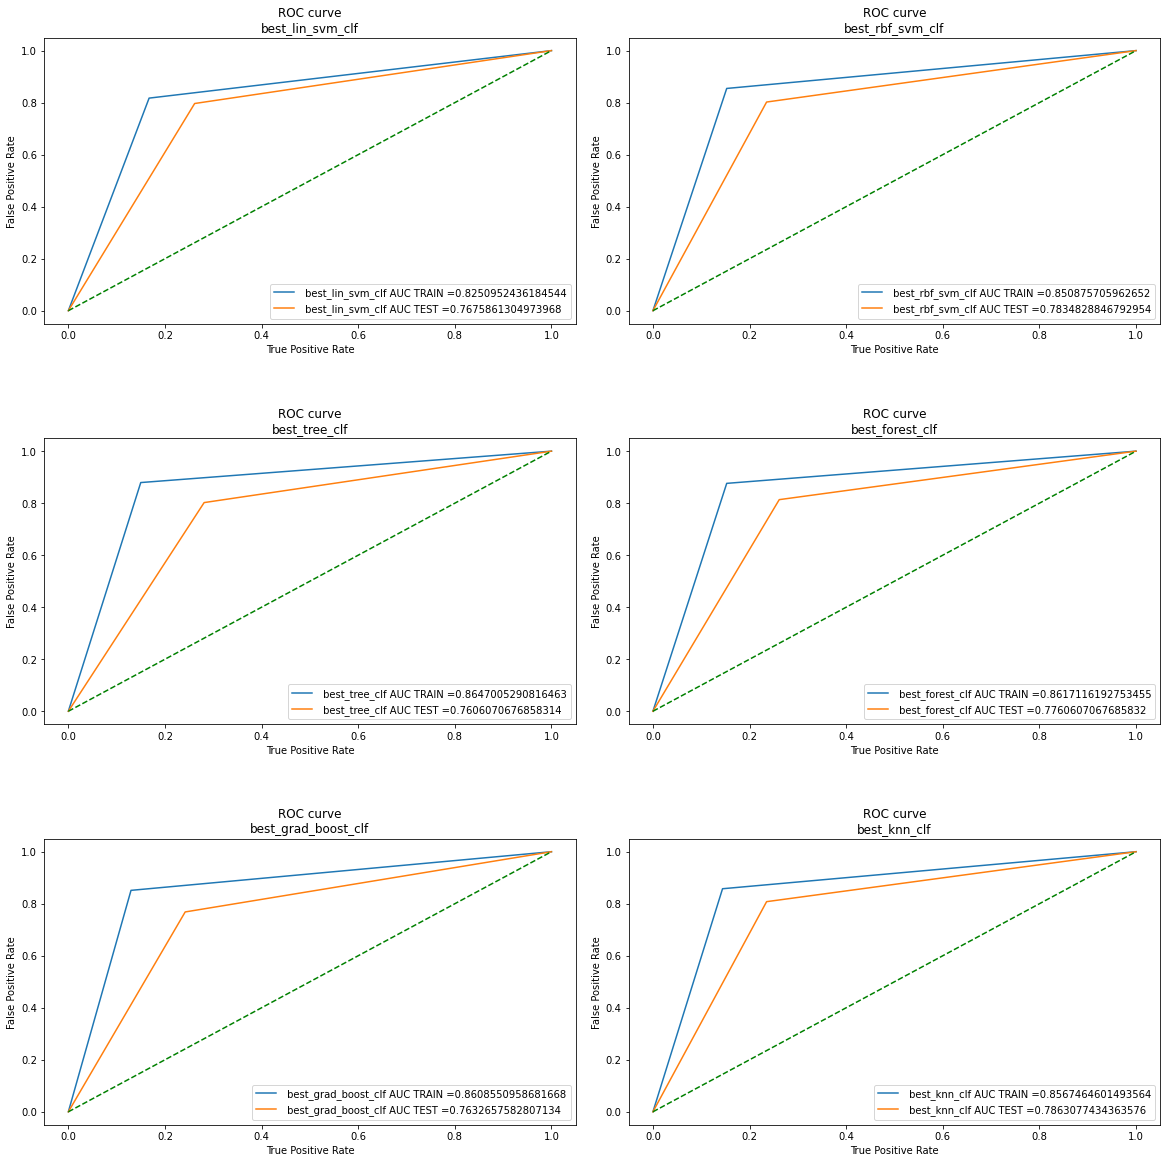

In [ ]:
auc_test = pd.DataFrame({'AUC': None}, index=clfs_name)
fig_roc, sub = plt.subplots(3, 2)
fig_roc.set_size_inches(20, 20)
plt.subplots_adjust(wspace=0.1, hspace=0.4)
for i, ax in zip(range(len(clfs)), sub.flatten()):
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_list[i])
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_list[i])
    auc_test['AUC'].loc[clfs_name[i]] = auc(test_fpr, test_tpr)
    ax.plot(train_fpr, train_tpr, label=f" {clfs_name[i]} AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
    ax.plot(test_fpr, test_tpr, label=f" {clfs_name[i]} AUC TEST ="+str(auc(test_fpr, test_tpr)))
    ax.plot([0,1],[0,1],'g--')
    ax.legend(loc='lower right')
    ax.set_xlabel("True Positive Rate")
    ax.set_ylabel("False Positive Rate")
    ax.set_title(f"ROC curve\n{clfs_name[i]}")
plt.show()

In [ ]:
auc_test

,AUC
best_lin_svm_clf,0.767586
best_rbf_svm_clf,0.783483
best_tree_clf,0.760607
best_forest_clf,0.776061
best_grad_boost_clf,0.763266
best_knn_clf,0.786308


In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
model_scores = pd.DataFrame(columns=clfs_name)
clfs_scores = pd.DataFrame({'mean_score': None, 'std_score': None}, index=clfs_name)
for i in range(len(clfs)):
    result =pd.Series(cross_validate(estimator=clfs[i], X=X_test, y=y_test, cv=cv, scoring='roc_auc'))['test_score']
    model_scores[clfs_name[i]] = result
    clfs_scores['mean_score'].loc[clfs_name[i]] = result.mean()
    clfs_scores['std_score'].loc[clfs_name[i]] = result.std()
model_scores = model_scores.T
model_scores

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
best_lin_svm_clf,0.891244,0.797235,0.789862,0.896296,0.849074,0.864516,0.892166,0.762212,0.860185,0.857407,...,0.873733,0.780645,0.823963,0.868519,0.890741,0.854378,0.872811,0.811982,0.761111,0.881481
best_rbf_svm_clf,0.870046,0.785253,0.788018,0.899074,0.838889,0.865438,0.884793,0.776959,0.858333,0.811111,...,0.877419,0.771429,0.823963,0.862963,0.877778,0.813825,0.847926,0.827650,0.762037,0.872222
best_tree_clf,0.821198,0.770968,0.792627,0.864815,0.759722,0.854839,0.864977,0.724424,0.818981,0.820833,...,0.801382,0.770046,0.779263,0.850926,0.829167,0.825346,0.798618,0.806452,0.712963,0.802778
best_forest_clf,0.868203,0.803687,0.789862,0.895370,0.872685,0.849770,0.874654,0.748387,0.872222,0.847685,...,0.871889,0.784793,0.822581,0.863426,0.879630,0.854839,0.845161,0.819355,0.756944,0.869907
best_grad_boost_clf,0.876037,0.800922,0.784793,0.877778,0.862500,0.850230,0.865438,0.733180,0.868519,0.825463,...,0.850691,0.777880,0.816129,0.875000,0.873611,0.848387,0.816129,0.829032,0.750000,0.850926
best_knn_clf,0.859447,0.789862,0.812903,0.888426,0.857407,0.859447,0.899539,0.787097,0.862500,0.841204,...,0.859447,0.798618,0.829493,0.880556,0.874537,0.827189,0.870968,0.833180,0.741204,0.871296


In [ ]:
clfs_scores.sort_values('mean_score', ascending=False)

,mean_score,std_score
best_lin_svm_clf,0.846064,0.039372
best_knn_clf,0.845692,0.037655
best_forest_clf,0.84163,0.040143
best_rbf_svm_clf,0.838381,0.043244
best_grad_boost_clf,0.831175,0.037781
best_tree_clf,0.803776,0.044536


In [ ]:
def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples, 1)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : int
        Variance-corrected standard deviation of the set of differences.
    """
    n = n_train + n_test
    corrected_var = (
        np.var(differences, ddof=1) * ((1 / n) + (n_test / n_train))
    )
    corrected_std = np.sqrt(corrected_var)
    return corrected_std

def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples, 1)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [ ]:
n_comparisons = (
    factorial(len(model_scores))
    / (factorial(2) * factorial(len(model_scores) - 2))
)
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    df = differences.shape[0] - 1
    t_stat, p_val = compute_corrected_ttest(
        differences, df, len(y_train), len(y_test)
    )
    p_val *= n_comparisons  # implement Bonferroni correction
    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val
    pairwise_t_test.append(
        [model_scores.index[model_i], model_scores.index[model_k],
         t_stat, p_val]
    )

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test,
    columns=['model_1', 'model_2', 't_stat', 'p_val']
).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,best_lin_svm_clf,best_rbf_svm_clf,0.452,1.000
1,best_lin_svm_clf,best_tree_clf,1.783,0.606
2,best_lin_svm_clf,best_forest_clf,0.497,1.000
3,best_lin_svm_clf,best_grad_boost_clf,1.184,1.000
4,best_lin_svm_clf,best_knn_clf,0.028,1.000
5,best_rbf_svm_clf,best_tree_clf,1.329,1.000
6,best_rbf_svm_clf,best_forest_clf,-0.191,1.000
7,best_rbf_svm_clf,best_grad_boost_clf,0.360,1.000
8,best_rbf_svm_clf,best_knn_clf,-0.628,1.000
9,best_tree_clf,best_forest_clf,-1.622,0.834


In [ ]:
pairwise_bayesian = []

rope_interval = [-0.01, 0.01]

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        df, loc=np.mean(differences),
        scale=corrected_std(differences, len(y_train), len(y_test))
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

pairwise_bayesian_df = (pd.DataFrame(
    pairwise_bayesian,
    columns=['worse_prob', 'better_prob', 'rope_prob']
).round(3))

pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
pairwise_comp_df

,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,best_lin_svm_clf,best_rbf_svm_clf,0.452,1.000,0.152,0.446,0.402
1,best_lin_svm_clf,best_tree_clf,1.783,0.606,0.016,0.910,0.074
2,best_lin_svm_clf,best_forest_clf,0.497,1.000,0.056,0.268,0.676
3,best_lin_svm_clf,best_grad_boost_clf,1.184,1.000,0.027,0.650,0.323
4,best_lin_svm_clf,best_knn_clf,0.028,1.000,0.219,0.236,0.546
5,best_rbf_svm_clf,best_tree_clf,1.329,1.000,0.046,0.825,0.128
6,best_rbf_svm_clf,best_forest_clf,-0.191,1.000,0.347,0.220,0.433
7,best_rbf_svm_clf,best_grad_boost_clf,0.360,1.000,0.197,0.445,0.358
8,best_rbf_svm_clf,best_knn_clf,-0.628,1.000,0.409,0.072,0.519
9,best_tree_clf,best_forest_clf,-1.622,0.834,0.881,0.023,0.096


In [ ]:
# Same, but with f metric
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
model_scores_f = pd.DataFrame(columns=clfs_name)
clfs_scores_f = pd.DataFrame({'mean_f_score': None, 'std_score': None}, index=clfs_name)
for i in range(len(clfs)):
    result =pd.Series(cross_validate(estimator=clfs[i], X=X_test, y=y_test, cv=cv, scoring='f1'))['test_score']
    model_scores_f[clfs_name[i]] = result
    clfs_scores_f['mean_f_score'].loc[clfs_name[i]] = result.mean()
    clfs_scores_f['std_score'].loc[clfs_name[i]] = result.std()
model_scores_f = model_scores_f.T

n_comparisons = (
    factorial(len(model_scores_f))
    / (factorial(2) * factorial(len(model_scores_f) - 2))
)
pairwise_t_test_f = []

for model_i, model_k in combinations(range(len(model_scores_f)), 2):
    model_i_scores = model_scores_f.iloc[model_i].values
    model_k_scores = model_scores_f.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    df = differences.shape[0] - 1
    t_stat, p_val = compute_corrected_ttest(
        differences, df, len(y_train), len(y_test)
    )
    p_val *= n_comparisons  # implement Bonferroni correction
    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val
    pairwise_t_test_f.append(
        [model_scores_f.index[model_i], model_scores_f.index[model_k],
         t_stat, p_val]
    )

pairwise_comp_df_f = pd.DataFrame(
    pairwise_t_test_f,
    columns=['model_1', 'model_2', 't_stat', 'p_val']
).round(3)
pairwise_bayesian_f = []

rope_interval = [-0.01, 0.01]

for model_i, model_k in combinations(range(len(model_scores_f)), 2):
    model_i_scores = model_scores_f.iloc[model_i].values
    model_k_scores = model_scores_f.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        df, loc=np.mean(differences),
        scale=corrected_std(differences, len(y_train), len(y_test))
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian_f.append([worse_prob, better_prob, rope_prob])

pairwise_bayesian_df_f = (pd.DataFrame(
    pairwise_bayesian_f,
    columns=['worse_prob', 'better_prob', 'rope_prob']
).round(3))

pairwise_comp_df_f = pairwise_comp_df_f.join(pairwise_bayesian_df_f)
pairwise_comp_df_f

,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,best_lin_svm_clf,best_rbf_svm_clf,0.439,1,0.187,0.491,0.322
1,best_lin_svm_clf,best_tree_clf,0.936,1,0.104,0.722,0.174
2,best_lin_svm_clf,best_forest_clf,0.866,1,0.075,0.605,0.320
3,best_lin_svm_clf,best_grad_boost_clf,0.888,1,0.092,0.664,0.244
4,best_lin_svm_clf,best_knn_clf,0.413,1,0.193,0.481,0.326
5,best_rbf_svm_clf,best_tree_clf,0.618,1,0.170,0.607,0.223
6,best_rbf_svm_clf,best_forest_clf,0.222,1,0.253,0.411,0.335
7,best_rbf_svm_clf,best_grad_boost_clf,0.387,1,0.218,0.495,0.287
8,best_rbf_svm_clf,best_knn_clf,-0.039,1,0.262,0.238,0.499
9,best_tree_clf,best_forest_clf,-0.470,1,0.542,0.204,0.254


In [ ]:
clfs_scores_f

,mean_f_score,std_score
best_lin_svm_clf,0.784551,0.043449
best_rbf_svm_clf,0.775021,0.041883
best_tree_clf,0.757138,0.045769
best_forest_clf,0.770058,0.044503
best_grad_boost_clf,0.765335,0.045824
best_knn_clf,0.775591,0.038317


In [ ]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

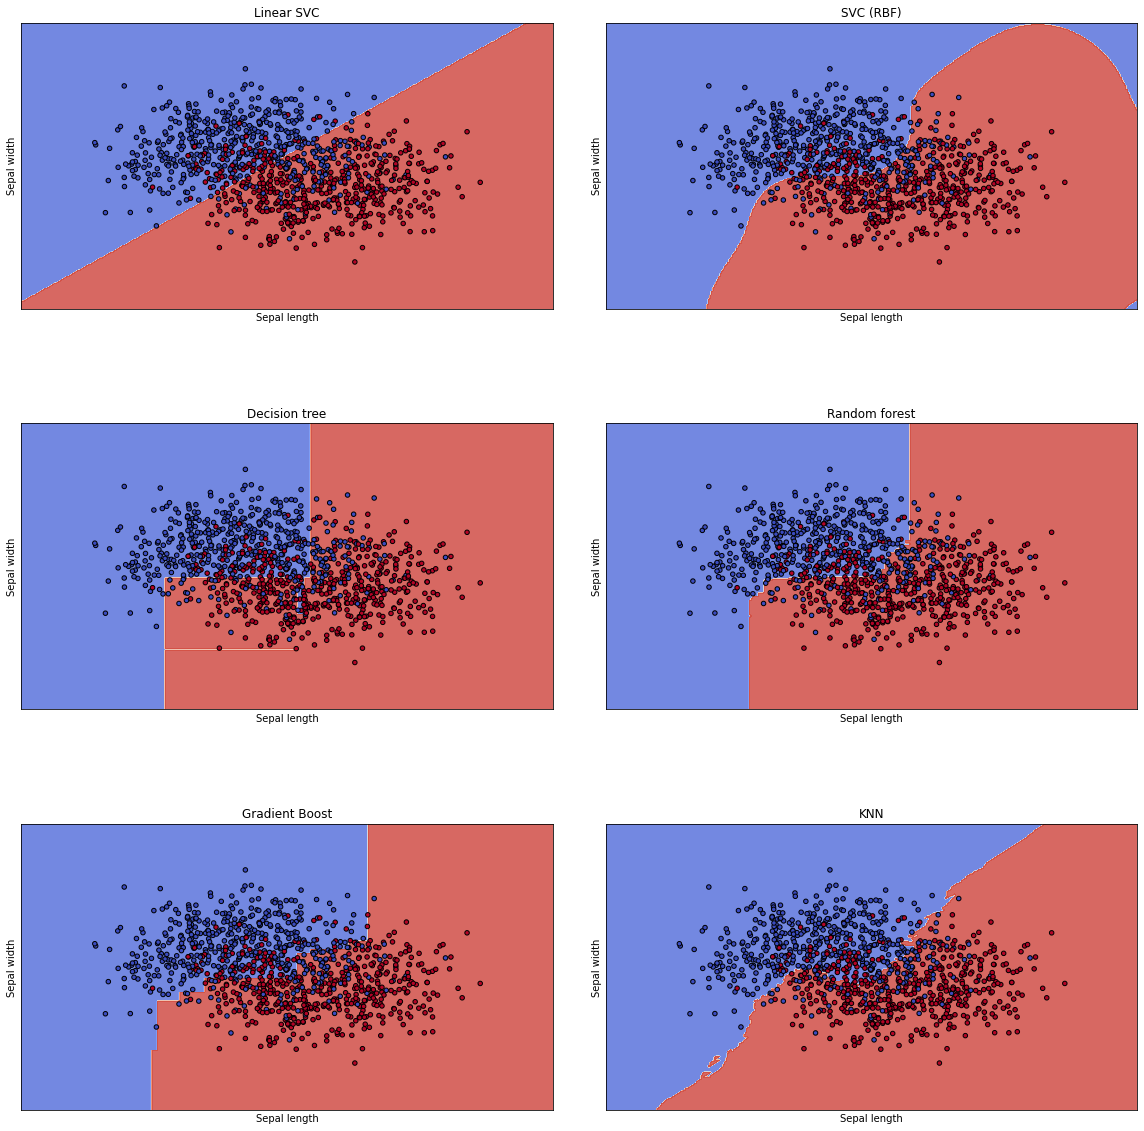

In [ ]:
# title for the plots
titles = ('Linear SVC',
          'SVC (RBF)',
          'Decision tree',
          'Random forest',
          'Gradient Boost',
          'KNN'
         )

# Set-up 2x2 grid for plotting.
fig_mesh, sub = plt.subplots(3, 2)
fig_mesh.set_size_inches(20, 20)
plt.subplots_adjust(wspace=0.1, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
for clf, title, ax in zip(clfs, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()

# Part three
## Discussion

So, we have moons dataset with rather high level of noise (0.5) and solved the ckassification task with six approaches:
* Linear SVM
* RBF SVM
* Decision tree
* Random forest
* Gradient boost
* KNN

Classifiers were fitted and parameters was tuned with Grid search method. Tuning was divided into three steps to reduce computation time

Firstly, let's look at ROC curves of classifiers and ROC AUC

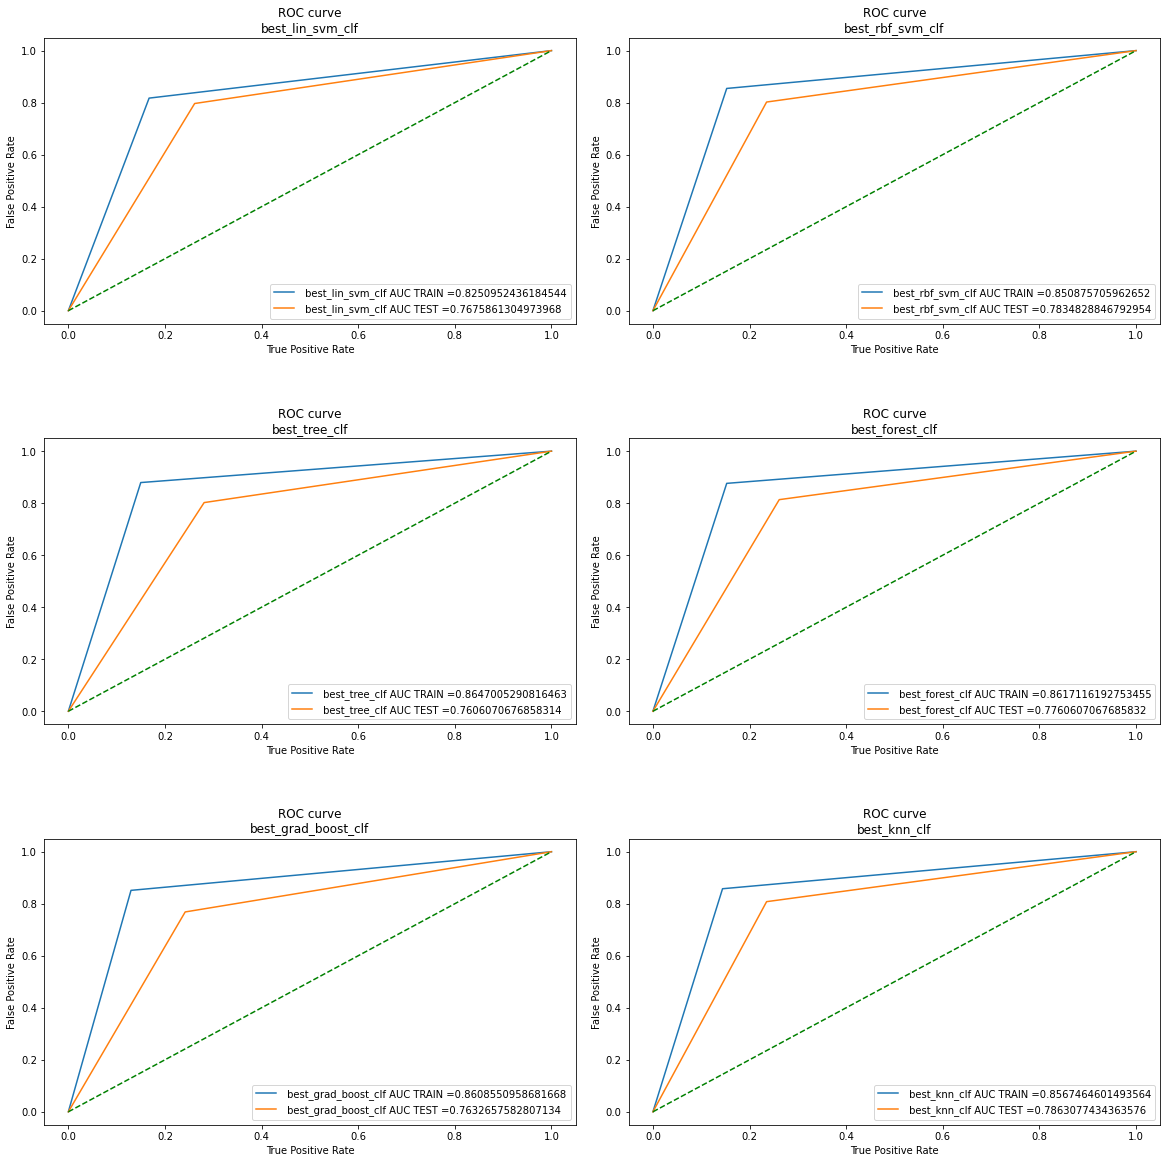

In [ ]:
fig_roc

In [ ]:
auc_test.sort_values('AUC', ascending=False)

,AUC
best_knn_clf,0.786308
best_rbf_svm_clf,0.783483
best_forest_clf,0.776061
best_lin_svm_clf,0.767586
best_grad_boost_clf,0.763266
best_tree_clf,0.760607


But obviously the only AUC score can't say realy reliable information which classifier solved task with best way

We don't know if these are statistically significant. To evaluate this, we need to conduct a statistical test. Specifically, to contrast the performance of two models we should statistically compare their AUC scores

However, the scores of the models are not independent: all models are evaluated on the same 100 partitions, increasing the correlation between the performance of the models. Since some partitions of the data can make the distinction of the classes particularly easy or hard to find for all models, the models scores will co-vary

Let's look at the results of crooss validation classifiers: 5 foild, 10 repeats, results - mean AUC score and std

In [ ]:
clfs_scores.sort_values('mean_score', ascending=False)

,mean_score,std_score
best_lin_svm_clf,0.846064,0.039372
best_knn_clf,0.845692,0.037655
best_forest_clf,0.84163,0.040143
best_rbf_svm_clf,0.838381,0.043244
best_grad_boost_clf,0.831175,0.037781
best_tree_clf,0.803776,0.044536


And here we can previously see that ranking is not similar with score values and another classifiers are the best

Also we can use the frequency approach and the Bayesian estimation to compare models

Here we can view the pairway comparison data:

In [ ]:
pairwise_comp_df

,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,best_lin_svm_clf,best_rbf_svm_clf,0.452,1.000,0.152,0.446,0.402
1,best_lin_svm_clf,best_tree_clf,1.783,0.606,0.016,0.910,0.074
2,best_lin_svm_clf,best_forest_clf,0.497,1.000,0.056,0.268,0.676
3,best_lin_svm_clf,best_grad_boost_clf,1.184,1.000,0.027,0.650,0.323
4,best_lin_svm_clf,best_knn_clf,0.028,1.000,0.219,0.236,0.546
5,best_rbf_svm_clf,best_tree_clf,1.329,1.000,0.046,0.825,0.128
6,best_rbf_svm_clf,best_forest_clf,-0.191,1.000,0.347,0.220,0.433
7,best_rbf_svm_clf,best_grad_boost_clf,0.360,1.000,0.197,0.445,0.358
8,best_rbf_svm_clf,best_knn_clf,-0.628,1.000,0.409,0.072,0.519
9,best_tree_clf,best_forest_clf,-1.622,0.834,0.881,0.023,0.096


And see the same with f metric:

In [ ]:
clfs_scores_f

,mean_f_score,std_score
best_lin_svm_clf,0.784551,0.043449
best_rbf_svm_clf,0.775021,0.041883
best_tree_clf,0.757138,0.045769
best_forest_clf,0.770058,0.044503
best_grad_boost_clf,0.765335,0.045824
best_knn_clf,0.775591,0.038317


In [ ]:
pairwise_comp_df_f

,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,best_lin_svm_clf,best_rbf_svm_clf,0.439,1,0.187,0.491,0.322
1,best_lin_svm_clf,best_tree_clf,0.936,1,0.104,0.722,0.174
2,best_lin_svm_clf,best_forest_clf,0.866,1,0.075,0.605,0.320
3,best_lin_svm_clf,best_grad_boost_clf,0.888,1,0.092,0.664,0.244
4,best_lin_svm_clf,best_knn_clf,0.413,1,0.193,0.481,0.326
5,best_rbf_svm_clf,best_tree_clf,0.618,1,0.170,0.607,0.223
6,best_rbf_svm_clf,best_forest_clf,0.222,1,0.253,0.411,0.335
7,best_rbf_svm_clf,best_grad_boost_clf,0.387,1,0.218,0.495,0.287
8,best_rbf_svm_clf,best_knn_clf,-0.039,1,0.262,0.238,0.499
9,best_tree_clf,best_forest_clf,-0.470,1,0.542,0.204,0.254


So, here we can see, that the worst method is probably decision tree approach. 
Inefficiency is probably caused by too low number of features

And one of the best model is linear svm approach, what is rather unexpected. The reason is in the data characteristic:
level of noice is high (0.5) and samples are very mixed in the interface

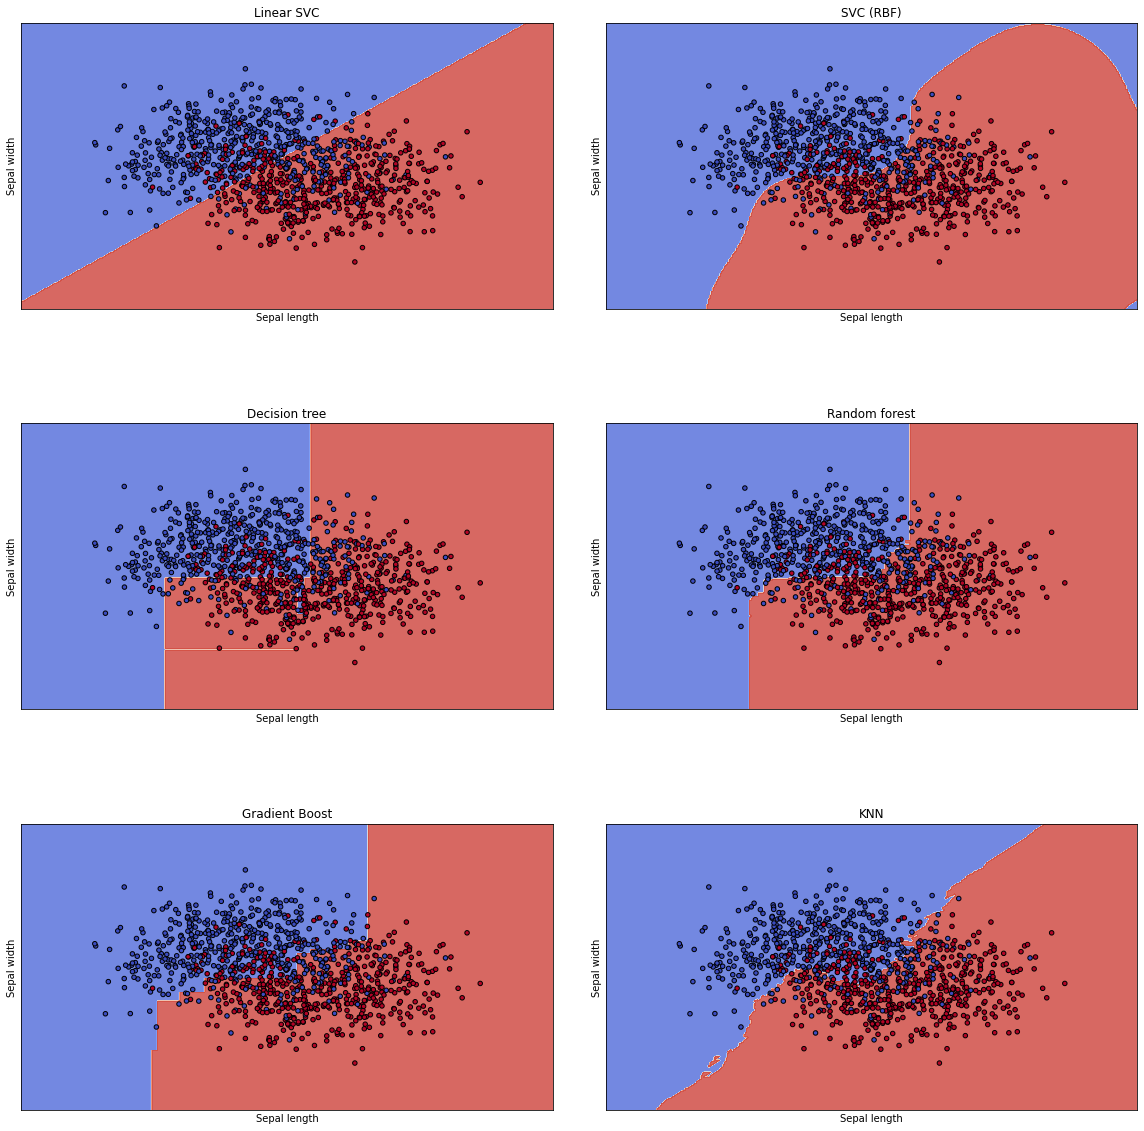

In [ ]:
fig_mesh

And even very flexible approaches will have a lot of mostakes, and it is the reason of general low level of scores.
And we can say that the high level of linear svc method's score is caused exactly with data distribution: mixing allow to define the boundary line, that misses a lot of details, but still predict dots quite effective. 

But it's very important, that if there would be less noisy data, linear method would had rather worst results comparing with non-linear

Besides linear svm models, rgb svm and knn approaches show quite good results, and the reason is clear: is't non linear and flexible methods that allow create rather good interface curve

# Conclusion

Summing up all the above:

There were fitted 6 classifiers for the challenge, all of them illutrated good above the average result and there is no huge difference between them. The reason of both conclusion lies in nature of dataset: it has quite high level of noice. So, no one algotithm has outstanding results and all of results are moderate

But approaches are not equivalent: best results has Linear SVM, RBF SVM and KNN models, worst - Decision tree

Linear SVM is good because of level of noice: simple line and efficiently classify most samples, and high mixing leads to non linear interfaces have comparable score: more chaos - less simple line to separate data

But such approaches as RBF SVM and KNN show themselves quite good, and the efficiency will increase with reducing the noice

Eventually, for that sample the best way is Linear SVM, but I'd prever RBF SVM and KNN models, because they are more common and universal for that dataset with non linear separation